In [1]:
import os
import sys
import time
import glob
import shutil
import argparse as argp
from functools import partial
import yaml
import numpy as np
import minkasi
#from jack_minkasi import minkasi
from astropy.coordinates import Angle
from astropy import units as u
import minkasi_jax.presets_by_source as pbs
from minkasi_jax.utils import *
from minkasi_jax import helper
from minkasi_jax.core import model

from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

importing mpi4py


In [2]:
from functools import partial
import jax
import jax.numpy as jnp
from minkasi_jax.utils import fft_conv
from minkasi_jax.structure import (
    isobeta,
    gnfw,
    gaussian,
    add_uniform,
    add_exponential,
    add_powerlaw,
    add_powerlaw_cos,
)

import jax.lax as lax

N_PAR_ISOBETA = 9
N_PAR_GNFW = 14
N_PAR_GAUSSIAN = 9
N_PAR_UNIFORM = 8
N_PAR_EXPONENTIAL = 14
N_PAR_POWERLAW = 11

ARGNUM_SHIFT = 11

@partial(
    jax.jit,
    static_argnums=(1, 2, 3, 4, 5, 6, 7, 8),
)
def model(
    xyz,
    n_isobeta,
    n_gnfw,
    n_gaussian,
    n_uniform,
    n_exponential,
    n_powerlaw,
    n_powerlaw_cos,
    dx,
    beam,
    idx,
    idy,
    *params
):
    """
    Generically create models with substructure.

    Arguments:

        xyz: Coordinate grid to compute profile on.

        n_isobeta: Number of isobeta profiles to add.

        n_gnfw: Number of gnfw profiles to add.

        n_gaussian: Number of gaussians to add.

        n_uniform: Number of uniform ellipsoids to add.

        n_exponential: Number of exponential ellipsoids to add.

        n_powerlaw: Number of power law ellipsoids to add.

        n_powerlaw_cos: Number of radial power law ellipsoids with angulas cos term to add.

        dx: Factor to scale by while integrating.
            Since it is a global factor it can contain unit conversions.
            Historically equal to y2K_RJ * dr * da * XMpc / me.

        beam: Beam to convolve by, should be a 2d array.

        idx: RA TOD in units of pixels.
             Should have Dec stretch applied.

        idy: Dec TOD in units of pixels.

        params: 1D array of model parameters.

    Returns:

        model: The model with the specified substructure.
    """
    params = jnp.array(params)
    params = jnp.ravel(params)
    isobetas = jnp.zeros((1, 1), dtype=float)
    gnfws = jnp.zeros((1, 1), dtype=float)
    gaussians = jnp.zeros((1, 1), dtype=float)
    uniforms = jnp.zeros((1, 1), dtype=float)
    exponentials = jnp.zeros((1, 1), dtype=float)
    powerlaws = jnp.zeros((1, 1), dtype=float)

    start = 0
    if n_isobeta:
        delta = n_isobeta * N_PAR_ISOBETA
        #isobetas = lax.slice(params, (1, start), (1, start + delta)).reshape((n_isobeta, N_PAR_ISOBETA))
        isobetas = params[start : start + delta].reshape((n_isobeta, N_PAR_ISOBETA))
        start += delta
    if n_gnfw:
        delta = n_gnfw * N_PAR_GNFW
        gnfws = params[start : start + delta].reshape((n_gnfw, N_PAR_GNFW))
        start += delta
    if n_gaussian:
        delta = n_gaussian * N_PAR_GAUSSIAN
        gaussians = params[start : start + delta].reshape((n_gaussian, N_PAR_GAUSSIAN))
        start += delta
    if n_uniform:
        delta = n_uniform * N_PAR_UNIFORM
        uniforms = params[start : start + delta].reshape((n_uniform, N_PAR_UNIFORM))
        start += delta
    if n_exponential:
        delta = n_exponential * N_PAR_EXPONENTIAL
        exponentials = params[start : start + delta].reshape(
            (n_exponential, N_PAR_EXPONENTIAL)
        )
        start += delta
    if n_powerlaw:
        delta = n_powerlaw * N_PAR_POWERLAW
        powerlaws = params[start : start + delta].reshape((n_powerlaw, N_PAR_POWERLAW))
        start += delta
    if n_powerlaw_cos:
        delta = n_powerlaw_cos * N_PAR_POWERLAW
        powerlaw_coses = params[start : start + delta].reshape(
            (n_powerlaw_cos, N_PAR_POWERLAW)
        )
        start += delta

    pressure = jnp.zeros((xyz[0].shape[1], xyz[1].shape[0], xyz[2].shape[2]))
    for i in range(n_isobeta):
        pressure = jnp.add(pressure, isobeta(*isobetas[i], xyz))

    for i in range(n_gnfw):
        pressure = jnp.add(pressure, gnfw(*gnfws[i], xyz))

    for i in range(n_gaussian):
        pressure = jnp.add(pressure, gaussian(*gaussians[i], xyz))

    for i in range(n_uniform):
        pressure = add_uniform(pressure, xyz, *uniforms[i])

    for i in range(n_exponential):
        pressure = add_exponential(pressure, xyz, *exponentials[i])

    for i in range(n_powerlaw):
        pressure = add_powerlaw(pressure, xyz, *powerlaws[i])

    for i in range(n_powerlaw_cos):
        pressure = add_powerlaw_cos(pressure, xyz, *powerlaw_coses[i])

    # Integrate along line of site
    ip = jnp.trapz(pressure, dx=dx, axis=-1)

    bound0, bound1 = int((ip.shape[0] - beam.shape[0]) / 2), int(
        (ip.shape[1] - beam.shape[1]) / 2
    )
    beam = jnp.pad(
        beam,
        (
            (bound0, ip.shape[0] - beam.shape[0] - bound0),
            (bound1, ip.shape[1] - beam.shape[1] - bound1),
        ),
    )

    print(idy.shape)

    ip = fft_conv(ip, beam)

    # return jsp.ndimage.map_coordinates(ip, (idy, idx), order=0)
    return ip[idy.ravel(), idx.ravel()].reshape(idx.shape)

In [3]:
def print_once(*args):
    """
    Helper function to print only once when running with MPI.
    Only the rank 0 process will print.

    Arguments:

        *args: Arguments to pass to print.
    """
    if minkasi.myrank == 0:
        print(*args)
        sys.stdout.flush()


In [4]:
import time

def timer(f, *args):
    starttime = time.time()
    result = f(*args)
    endtime = time.time()
    return endtime - starttime

In [5]:
with open('/home/r/rbond/jorlo/dev/minkasi_jax/configs/ms0735_noSub.yaml', "r") as file:
    cfg = yaml.safe_load(file)
#with open('/home/r/rbond/jorlo/dev/minkasi_jax/configs/ms0735/ms0735.yaml', "r") as file:
#    cfg = yaml.safe_load(file)
fit = True

# Setup coordindate stuff
z = eval(str(cfg["coords"]["z"]))
da = get_da(z)
r_map = eval(str(cfg["coords"]["r_map"]))
dr = eval(str(cfg["coords"]["dr"]))
xyz = make_grid(r_map, dr)
coord_conv = eval(str(cfg["coords"]["conv_factor"]))
x0 = eval(str(cfg["coords"]["x0"]))
y0 = eval(str(cfg["coords"]["y0"]))

# Load TODs
tod_names = glob.glob(os.path.join(cfg["paths"]["tods"], cfg["paths"]["glob"]))
bad_tod, addtag = pbs.get_bad_tods(
    cfg["cluster"]["name"], ndo=cfg["paths"]["ndo"], odo=cfg["paths"]["odo"]
)
tod_names = minkasi.cut_blacklist(tod_names, bad_tod)
tod_names.sort()
tod_names = tod_names[minkasi.myrank :: minkasi.nproc]
print('tod #: ', len(tod_names))
minkasi.barrier()  # Is this needed?

#idx = np.random.randint(-307, 1058, (899454,))
#idy = np.random.randint(-307, 1058, (899454,))

tod #:  285


In [6]:
todvec = minkasi.TodVec()
n_tod = 10
for i, fname in enumerate(tod_names):
    if i >= n_tod: break
    dat = minkasi.read_tod_from_fits(fname)
    minkasi.truncate_tod(dat)

    # figure out a guess at common mode and (assumed) linear detector drifts/offset
    # drifts/offsets are removed, which is important for mode finding.  CM is *not* removed.
    dd, pred2, cm = minkasi.fit_cm_plus_poly(dat["dat_calib"], cm_ord=3, full_out=True)
    dat["dat_calib"] = dd
    dat["pred2"] = pred2
    dat["cm"] = cm

    # Make pixelized RA/Dec TODs
    idx, idy = tod_to_index(dat["dx"], dat["dy"], x0, y0, r_map, dr, coord_conv)
    idu, id_inv = np.unique(
        np.vstack((idx.ravel(), idy.ravel())), axis=1, return_inverse=True
    )
    dat["idx"] = idu[0]
    dat["idy"] = idu[1]
    dat["id_inv"] = id_inv
    dat["model_idx"] = idx
    dat["model_idy"] = idy

    tod = minkasi.Tod(dat)
    todvec.add_tod(tod)

WARNING - calinfo information not found in fits file header - to track JytoK etc you may need to reprocess the fits files using mustangidl > revision 932
nsamp and ndet are  182 24707.0 4496674  on  /scratch/r/rbond/jorlo/MS0735/TS_EaCMS0f0_51_5_Oct_2021/Signal_TOD-AGBT19A_092_01-s12.fits with lims  115.13548797090777 115.79331715025005 74.15935947949289 74.334082548651
truncating from  24707  to  24697
WARNING - calinfo information not found in fits file header - to track JytoK etc you may need to reprocess the fits files using mustangidl > revision 932
nsamp and ndet are  179 24708.0 4422732  on  /scratch/r/rbond/jorlo/MS0735/TS_EaCMS0f0_51_5_Oct_2021/Signal_TOD-AGBT19A_092_01-s13.fits with lims  115.13373944248026 115.79094024441889 74.15967366819471 74.33531881289076
truncating from  24708  to  24697
WARNING - calinfo information not found in fits file header - to track JytoK etc you may need to reprocess the fits files using mustangidl > revision 932
nsamp and ndet are  184 24708.

In [7]:
lims = todvec.lims()
pixsize = 2.0 / 3600 * np.pi / 180
skymap = minkasi.SkyMap(lims, pixsize)

Te = eval(str(cfg["cluster"]["Te"]))
freq = eval(str(cfg["cluster"]["freq"]))
beam = beam_double_gauss(
    dr,
    eval(str(cfg["beam"]["fwhm1"])),
    eval(str(cfg["beam"]["amp1"])),
    eval(str(cfg["beam"]["fwhm2"])),
    eval(str(cfg["beam"]["amp2"])),
)

funs = []
npars = []
labels = []
params = []
to_fit = []
priors = []
prior_vals = []
re_eval = []
par_idx = {}
for cur_model in cfg["models"].values():
    npars.append(len(cur_model["parameters"]))
    for name, par in cur_model["parameters"].items():
        labels.append(name)
        par_idx[name] = len(params)
        params.append(eval(str(par["value"])))
        to_fit.append(eval(str(par["to_fit"])))
        if "priors" in par:
            priors.append(par["priors"]["type"])
            prior_vals.append(eval(str(par["priors"]["value"])))
        else:
            priors.append(None)
            prior_vals.append(None)
        if "re_eval" in par and par["re_eval"]:
            re_eval.append(str(par["value"]))
        else:
            re_eval.append(False)
        2.627 * da, funs.append(eval(str(cur_model["func"])))

npars = np.array(npars)
labels = np.array(labels)
params = np.array(params)
to_fit = np.array(to_fit, dtype=bool)
priors = np.array(priors)

noise_class = eval(str(cfg["minkasi"]["noise"]["class"]))
noise_args = eval(str(cfg["minkasi"]["noise"]["args"]))
noise_kwargs = eval(str(cfg["minkasi"]["noise"]["kwargs"]))

In [8]:
#TODO: Implement tsBowl here 
if "bowling" in cfg:
    sub_poly = cfg["bowling"]["sub_poly"]

sim = False #This script is for simming, the option to turn off is here only for debugging
from minkasi_jax.core import model
#TODO: Write this to use minkasi_jax.core.model
for i, tod in enumerate(todvec.tods):
    
    temp_tod = tod.copy()
    if sim:
        pred = model(
            xyz,
            1,
            0,
            0,
            0,
            0,
            0,
            0,
            float(y2K_RJ(freq, Te)*dr*XMpc/me),
            beam,
            tod.info["idx"],
            tod.info["idy"],
            params
        )  

    if (sim) and ("id_inv" in tod.info):
        id_inv = tod.info["id_inv"]
        shape = tod.info["dx"].shape
        pred = pred[id_inv].reshape(shape)
        
    ipix = skymap.get_pix(tod)
    tod.info["ipix"] = ipix
    tod.set_noise(noise_class, *noise_args, **noise_kwargs)
    if sim:
        #Flip alternate TODs and add simulated profile on top
        if (i % 2) == 0:
            tod.info['dat_calib'] = -1*tod.info['dat_calib']
        else:
            tod.info['dat_calib'] = tod.info['dat_calib']

        tod.info['dat_calib'] = tod.info['dat_calib'] + np.array(pred)

got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd
got svd


In [9]:
# Figure out output
outdir = os.path.join(
    cfg["paths"]["outroot"],
    cfg["cluster"]["name"],
    "-".join(mn for mn in cfg["models"].keys()),
)
if "subdir" in cfg["paths"]:
    outdir = os.path.join(outdir, cfg["paths"]["subdir"])
if fit:
    outdir = os.path.join(outdir, "-".join(l for l in labels[to_fit]))
else:
    outdir = os.path.join(outdir, "not_fit")
if sub_poly:
    outdir += "-" + method + "_" + str(degree)
if sim:
    outdir += "-" + "sim"
print_once("Outputs can be found in", outdir)

Outputs can be found in /scratch/r/rbond/jorlo/Reductions/MS0735/double_isobeta_shock_bubbles-gauss/r1=r3/amp_1-amp_2-shock_val-b_ne_sup-b_sw_sup-sigma-amp


# Timing getchis

In [11]:
from minkasi import mkfftw
import jax.scipy as jsp
import scipy as sp


def prep_data(dat, pred, v, weight):
    resid = dat - pred
    pred = pred.at[:,0].set((0.5*pred)[:,0])
    pred = pred.at[:,-1].set((0.5*pred)[:,-1])
    pred_rot = jnp.dot(v,pred)

    return pred_rot

jprep = jax.jit(prep_data)

def calc_chi_from_ft(predft, weight):
    nn=predft.shape[1]
    chisq = jnp.sum(weight[:,:nn]*predft**2)
    return chisq

jcalc_chi_from_ft = jax.jit(calc_chi_from_ft)

def get_chis(dat, pred, v, weight):
    resid = dat - pred
    pred = pred.at[:,0].set((jnp.sqrt(0.5)*pred)[:,0])
    pred = pred.at[:,-1].set((jnp.sqrt(0.5)*pred)[:,-1])
    pred_rot = jnp.dot(v,pred)
    tmp=jnp.hstack([pred_rot,jnp.fliplr(pred_rot[:,1:-1])]) #mirror pred so we can do dct of second kind
    predft=jnp.real(jnp.fft.rfft(tmp,axis=1))
    nn=predft.shape[1]
    chisq = jnp.sum(weight[:,:nn]*predft**2)    
    return chisq

def vget_chis(dat, pred, weight):
    print(dat.shape, pred.shape, v.shape, weight.shape)
    resid = dat - pred
    pred = pred.at[0].set((0.5*pred)[0])
    pred = pred.at[-1].set((0.5*pred)[-1])
    pred_rot = jnp.dot(v,pred)
    predft = jnp.fft.rfft(pred_rot)
    nn=predft.shape[1]
    chisq = jnp.sum(weight[:,:nn]*predft**2)
    return chisq

jget_chis = jax.jit(get_chis)



In [12]:
new_pars = jnp.array([0.0,0.0,0.0,.341,.249,.341,np.deg2rad(97),0.98,1e-5,
                      0.0,0.0,0.0,.167,.122,.167,np.deg2rad(97),8.93,1e-5])    

In [62]:
weight = tod.noise.mywt
v = tod.noise.v
idx, idy = tod.info["model_idx"], tod.info["model_idy"]
pred = model(xyz, 2, 0, 0, 0, 0, 0, 0, float(y2K_RJ(freq, Te)*dr*XMpc/me), beam, idx, idy, new_pars)
dat = tod.info["dat_calib"]

In [63]:
get_chis(dat, pred, v, weight)

DeviceArray(6.674461e-06, dtype=float64)

In [71]:
data = np.random.rand(10000)
import scipy

R = 100

ts = time.time()
for i in range(R):
    scipy.fft.dct(dat, type=1)
print('scipy execution time [ms]:\t', (time.time()-ts)/R * 1000)

R = 100

ts = time.time()
for i in range(R):
    mkfftw.fft_r2r(dat)
print('mkfftw execution time [ms]:\t', (time.time()-ts)/R * 1000)

jdcnt = jax.jit(jsp.fft.dct)
jdcnt(dat)

ts = time.time()
for i in range(R):
    jdcnt(dat)
print('jdcnt execution time [ms]:\t', (time.time()-ts)/R * 1000)


def jax_r2r(dat):
    tmp=jnp.hstack([dat,jnp.fliplr(dat[:,1:-1])]) #mirror pred so we can do dct of second kind
    predft=jnp.real(jnp.fft.rfft(tmp,axis=1))
    return predft

jjax_r2r = jax.jit(jax_r2r)
jjax_r2r(dat)

ts = time.time()
for i in range(R):
    jjax_r2r(dat)

print('jax_r2r execution time [ms]:\t', (time.time()-ts)/R * 1000)



scipy execution time [ms]:	 79.74332809448242
mkfftw execution time [ms]:	 5.1248860359191895
jdcnt execution time [ms]:	 4.503383636474609
jax_r2r execution time [ms]:	 4.362087249755859


In [66]:
R = 100

ts = time.time()
for i in range(R):
    #pred_rot = jprep(dat, pred, v, weight)
    #predft = sp.fft.dct(np.array(pred_rot), type=1)
    #chisq = jcalc_chi_from_ft(predft, weight)
    get_chis(dat, pred, v, weight)
print('jget_chis execution time [ms]:\t', (time.time()-ts)/R * 1000)


jget_chis execution time [ms]:	 23.835997581481934


In [67]:
jget_chis = jax.jit(get_chis)
jget_chis(dat, pred, v, weight)

DeviceArray(6.674461e-06, dtype=float64)

In [68]:
R = 100

ts = time.time()
for i in range(R):
    jget_chis(dat, pred, v, weight).block_until_ready()
print('jget_chis execution time [ms]:\t', (time.time()-ts)/R * 1000)


jget_chis execution time [ms]:	 6.867613792419434


In [16]:
jsample = jax.jit(sample)

tods = []

for tod in todvec.tods:
    tods.append([tod.info["model_idx"], tod.info["model_idy"], tod.info["dat_calib"], tod.noise.v, tod.noise.mywt])
    

sample(tods)

DeviceArray(1.51319183e-05, dtype=float64)

In [ ]:
times = np.zeros(20);

for i in range(len(times)):
    
    R = 100
    
    ts = time.time()
    for j in range(R):
        jsample(tods[:i]).block_until_ready()
    times[i] = (time.time()-ts)/R * 1000


In [ ]:
plt.plot(times)

In [26]:
temp_tod = np.array(tod.info["dat_calib"])
idx, idy = tod.info["model_idx"], tod.info["model_idy"]
#pred = model(xyz, 2, 0, 0, 0, 0, 0, 0, float(y2K_RJ(freq, Te)*dr*XMpc/me), beam, idx, idy, new_pars)
jfft = jax.jit(jnp.fft.rfft)
 
def just_fft(tod, pred):
    resid = tod - pred
    _ = jfft(resid)
vfft = jax.vmap(just_fft)
jvfft = jax.jit(vfft)
jjust_fft = jax.jit(just_fft)

In [27]:
fake_tod = np.random.rand(150, 10000)
fake_pred = np.random.rand(150, 10000)


In [31]:
#No vmap speed up for fft

R = 100

ts = time.time()
for i in range(R):
    jvfft(fake_tod, fake_pred)
print('vmap fft execution time [ms]:\t', (time.time()-ts)/R * 1000)

ts = time.time()
for i in range(R):
    jjust_fft(fake_tod, fake_pred)
print('vmap fft execution time [ms]:\t', (time.time()-ts)/R * 1000)

vmap fft execution time [ms]:	 1.1209344863891602
vmap fft execution time [ms]:	 1.1193156242370605


In [18]:

                      #0.0,0.0,0.0,.320,.320,.320,np.deg2rad(97),0.26])

idx, idy = np.array([]), np.array([])

for tod in todvec.tods:
    idx = np.append(idx, tod.info['model_idx'])
    idy = np.append(idy, tod.info['model_idy'])

print(idx.shape)

(43145659,)


In [22]:
id_inv = tod.info["id_inv"]
shape = tod.info["dx"].shape
#pred = pred[id_inv].reshape(shape)


In [20]:
starttime = time.time()
model(xyz, 2, 0, 0, 0, 0, 0, 0, float(y2K_RJ(freq, Te)*dr*XMpc/me), beam, tod.info["model_idx"], tod.info["model_idy"], new_pars).block_until_ready()
endtime = time.time()
    
print(endtime-starttime)

0.04680347442626953


In [52]:
import time
import numpy as np

import jax
from jax import numpy as jnp

from minkasi import mkfftw

residuals = tod.info["dat_calib"] - model(xyz, 2, 0, 0, 0, 0, 0, 0, float(y2K_RJ(freq, Te)*dr*XMpc/me), beam, idx, idy, params)

jfft = jax.jit(jnp.fft.rfft)

R = 100

ts = time.time()
for i in range(R):
    _ = jfft(residuals).block_until_ready()
print('jax fft execution time [ms]:\t', (time.time()-ts)/R * 1000)

jax fft execution time [ms]:	 1.3693642616271973


In [40]:
fftw_res = np.array(residuals)

R = 100

ts = time.time()
for i in range(R):
    _ = mkfftw.fft_r2r(fftw_res)
print('mkfftw fft execution time [ms]:\t', (time.time()-ts)/R * 1000)



mkfftw fft execution time [ms]:	 4.868004322052002


# Only do model once

In [75]:
#Set up big arrays of all idxs that we need

idxs = np.array([])
idys = np.array([])

dxs = np.array([])
dys = np.array([])

lens = np.array([])

for tod in todvec.tods:
    idxs = np.append(idxs, tod.info["idx"])
    idys = np.append(idys, tod.info["idy"])
    lens = np.append(lens, len(tod.info["dx"].ravel()))
    dxs = np.append(dxs, tod.info["model_idx"])
    dys = np.append(dys, tod.info["model_idy"])

lens = np.array(lens, dtype=int)

In [76]:
new_pars = jnp.array([0.0,0.0,0.0,.341,.249,.341,np.deg2rad(97),0.98,1e-6,
                      0.0,0.0,0.0,.167,.122,.167,np.deg2rad(97),8.93,1e-5])  



In [71]:
idu, id_inv = np.unique(
    np.vstack((dxs.ravel(), dys.ravel())), axis=1, return_inverse=True
)

idx_test, idy_test = np.array(idu[0], dtype=int), np.array(idu[1], dtype=int)


In [82]:
pred = model(xyz, 2, 0, 0, 0, 0, 0, 0, float(y2K_RJ(freq, Te)*dr*XMpc/me), beam, idx_test, idy_test, new_pars)

In [ ]:
shape = tod.info["dx"].shape
pred = pred[id_inv]#.reshape(shape)

for i, tod in enumerate(todvec.tods):
    print(i)
    shape = tod.info["dx"].shape
    start = sum(lens[:i])
    cur_id_inv = id_inv[start : start + lens[i]]
    print(pred[cur_id_inv].reshape(shape).shape)
    print(tod.info["dat_calib"].shape)

# Put it together

In [80]:

def sample(tods, idx_model, idy_model, lens, id_inv, shapes):
    chi2 = 0
    toc = time.time()
    pred = model(xyz, 2, 0, 0, 0, 0, 0, 0, -2.4995998836322247e-05, beam, idx_model, idy_model, new_pars)
    tic = time.time()
    print('model: ', (tic-toc)*1000)

    time_reshape = 0
    time_chi = 0
    time_model = 0

    for i, tod in enumerate(tods):
        #TODO: this doesn't jit cause the slicing pred based off the individual indicies doesn't work.
        #Could try; make np.zeros arrays for dat and pred which have shape (max_det, max_samp), where 
        #max_det and max_samp are taken over all tods. Then assign pad_dat[:] = dat, pad_pred[:] = pred although
        #that won't exactly work
        idx_tod, idy_tod, dat, v, weight = tod
        shape = shapes[i]
        start = sum(lens[:i])
        #end = start + lens[i]
        cur_id_inv = id_inv[start : start + lens[i]]
        cur_pred = pred[cur_id_inv].reshape(shape)
        #cur_pred = get_pred(pred, shape, start, start + lens[i])


        #Uncomment to get 
        #toc = time.time()
        #_ = model(xyz, 2, 0, 0, 0, 0, 0, 0, -2.4995998836322247e-05, beam, idx_tod, idy_tod, new_pars)
        #tic = time.time()
        time_model += tic-toc

        time_reshape += (tic-toc)
        toc = time.time()
        chi2 += jget_chis(dat, cur_pred, v, weight) #TODO, is it faster to not ravel here and to instead reshape cur_pred?
        tic = time.time()
        #print('chis2: ', (tic-toc)*1000)
        time_chi += tic-toc
    print('reshape: ', time_reshape*1000)
    print('chi2 :', time_chi*1000)
    print('model :', time_model*1000)

    return chi2


def get_pred(pred, shape, start, stop):
    cur_id_inv = lax.slice(id_inv, (start,), (stop,))#id_inv[start : stop]
    cur_pred = pred[cur_id_inv].reshape(shape)
    return cur_pred

jget_pred = jax.jit(get_pred)

def sample_wrapper(todvec):
    idxs = np.array([])
    idys = np.array([])
    
    dxs = np.array([])
    dys = np.array([])
    
    lens = np.array([])

    shapes = np.array([])
    
    for tod in todvec.tods:
        idxs = np.append(idxs, tod.info["idx"])
        idys = np.append(idys, tod.info["idy"])
        lens = np.append(lens, len(tod.info["dx"].ravel()))
        dxs = np.append(dxs, tod.info["model_idx"])
        dys = np.append(dys, tod.info["model_idy"])
        shapes = np.append(shapes, tod.info["dx"].shape, dtype=int)
    
    lens = np.array(lens, dtype=int)

    idu, id_inv = np.unique(
        np.vstack((dxs.ravel(), dys.ravel())), axis=1, return_inverse=True
    )
    
    idx_model, idy_model = np.array(idu[0], dtype=int), np.array(idu[1], dtype=int)

    #un wrap stuff cause jit doesn't like having tod objects
    tods = []

    for tod in todvec.tods:
        tods.append([tod.info["model_idx"], tod.info["model_idy"], tod.info["dat_calib"], tod.noise.v, tod.noise.mywt])



In [75]:
new_pars = jnp.array([0.0,0.0,0.0,.341,.249,.341,np.deg2rad(97),0.98,1e-6,
                      0.0,0.0,0.0,.167,.122,.167,np.deg2rad(97),8.93,1e-5])  

idxs = np.array([])
idys = np.array([])

dxs = np.array([])
dys = np.array([])

lens = np.array([])

shapes = np.zeros((len(todvec.tods),2), dtype=int)

for i,tod in enumerate(todvec.tods):
    idxs = np.append(idxs, tod.info["idx"])
    idys = np.append(idys, tod.info["idy"])
    lens = np.append(lens, len(tod.info["dx"].ravel()))
    dxs = np.append(dxs, tod.info["model_idx"])
    dys = np.append(dys, tod.info["model_idy"])
    shapes[i] = np.array(tod.info["dx"].shape, dtype=int)

lens = np.array(lens, dtype=int)

idu, id_inv = np.unique(
    np.vstack((dxs.ravel(), dys.ravel())), axis=1, return_inverse=True
)

idx_model, idy_model = np.array(idu[0], dtype=int), np.array(idu[1], dtype=int)

#un wrap stuff cause jit doesn't like having tod objects
tods = []

for tod in todvec.tods:
    tods.append([tod.info["idx"], tod.info["idy"], tod.info["dat_calib"], tod.noise.v, tod.noise.mywt])


In [82]:
sample(tods, idx_model, idy_model, lens, id_inv, shapes)


model:  1.50299072265625
reshape:  53.76935005187988
chi2 : 62.332868576049805


DeviceArray(2.4312628e-07, dtype=float64)

In [83]:
R = 100

ts = time.time()
for i in range(R):
    sample(tods, idx_model, idy_model, lens, id_inv, shapes).block_until_ready()
print('sample execution time [ms]:\t', (time.time()-ts)/R * 1000)

model:  1.4553070068359375
reshape:  43.24150085449219
chi2 : 57.37185478210449
model:  1.398324966430664
reshape:  43.25580596923828
chi2 : 57.50870704650879
model:  1.3413429260253906
reshape:  43.29037666320801
chi2 : 57.419776916503906
model:  1.3697147369384766
reshape:  43.238162994384766
chi2 : 57.270050048828125
model:  1.3697147369384766
reshape:  43.451786041259766
chi2 : 57.4343204498291
model:  1.3659000396728516
reshape:  43.24483871459961
chi2 : 57.219505310058594
model:  1.3456344604492188
reshape:  43.13540458679199
chi2 : 57.570457458496094
model:  1.3580322265625
reshape:  43.22481155395508
chi2 : 57.31368064880371
model:  1.394510269165039
reshape:  43.29824447631836
chi2 : 57.2965145111084
model:  1.38092041015625
reshape:  43.26605796813965
chi2 : 57.23690986633301
model:  1.367807388305664
reshape:  43.14470291137695
chi2 : 57.22522735595703
model:  1.3835430145263672
reshape:  43.24793815612793
chi2 : 57.268381118774414
model:  1.3959407806396484
reshape:  43.223

In [18]:
times = np.zeros(9);

for i in range(len(times)):
    
    R = 100
    
    ts = time.time()
    for j in range(R):
        sample(tods[:i+1], idx_model, idy_model, lens, id_inv, shapes).block_until_ready()
    times[i] = (time.time()-ts)/R * 1000

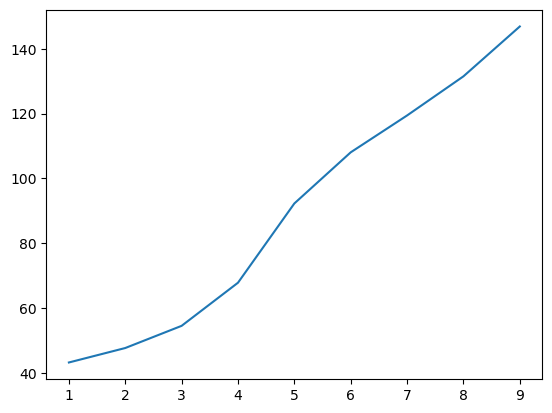

In [20]:
plt.plot(np.arange(1,10), times)

# Visualize model

In [78]:
idx_min, idx_max = np.min(idxs), np.max(idxs)
idy_min, idy_max = np.min(idys), np.max(idys)

In [79]:
x = np.arange(idx_min, idx_max, dtype = int)
y = np.arange(idy_min, idy_max, dtype = int)

X, Y = np.meshgrid(x, y)

#X, Y = np.ravel(X), np.ravel(Y)

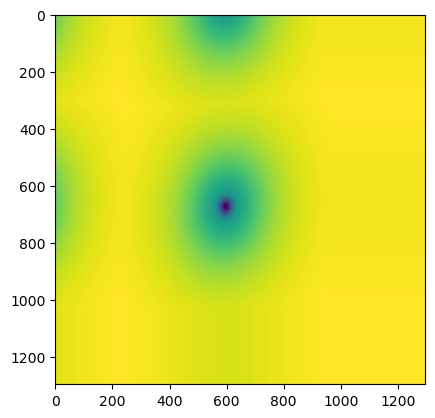

In [80]:
vis_model = model(xyz, 2, 0, 0, 0, 0, 0, 0, float(y2K_RJ(freq, Te)*dr*XMpc/me), beam, X, Y, new_pars)

plt.imshow(vis_model)

In [ ]:
pars_fit = params
if fit:
    t1 = time.time()
    print_once("Started actual fitting")
    pars_fit, chisq, curve, errs = minkasi.fit_timestreams_with_derivs_manyfun(
        funs,
        params,
        npars,
        todvec,
        to_fit,
        maxiter=cfg["minkasi"]["maxiter"],
        priors=priors,
        prior_vals=prior_vals,
    )
    minkasi.comm.barrier()
    t2 = time.time()
    print_once("Took", t2 - t1, "seconds to fit")

    for i, re in enumerate(re_eval):
        if not re:
            continue
        pars_fit[i] = eval(re)

    print_once("Fit parameters:")
    for l, pf, err in zip(labels, pars_fit, errs):
        print_once("\t", l, "=", pf, "+/-", err)
    print_once("chisq =", chisq)

    if minkasi.myrank == 0:
        res_path = os.path.join(outdir, "results")
        print_once("Saving results to", res_path + ".npz")
        np.savez_compressed(
            res_path, pars_fit=pars_fit, chisq=chisq, errs=errs, curve=curve
        )